In [1]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import config # Create config.py file where you declare database_url

In [2]:
database_uri = config.database_url
engine = create_engine(database_uri)

In [3]:
table_name = 'orderbook_imbalance_trades'
query = f"SELECT * FROM {table_name}"

df = pd.read_sql_query(query, engine)

In [4]:
df = df[df['orderbook_imbalance_1'] != -1]

In [5]:
df

,id,symbol,timestamp,trade_id,side,amount,price,orderbook_imbalance_1,orderbook_imbalance_5,orderbook_imbalance_10,orderbook_imbalance_25,orderbook_imbalance_50
0,1,ETHUSDT,1706047423193,983487c2-a663-520b-8b66-0c59080a8ce5,buy,4.420,2203.69,0.56,0.89,0.90,0.18,0.24
1,2,ETHUSDT,1706047423193,7c759ce8-4464-5212-834e-260770cd8a90,buy,0.100,2203.70,0.56,0.89,0.90,0.18,0.24
2,3,ETHUSDT,1706047423193,83878f8c-d881-5489-a191-7f7f3fabb7ad,buy,0.100,2203.70,0.56,0.89,0.90,0.18,0.24
3,4,ETHUSDT,1706047423193,04d18f24-a6f2-565d-994e-77da1f6f584d,buy,2.090,2203.71,0.56,0.89,0.90,0.18,0.24
4,5,ETHUSDT,1706047423193,13b54885-cdad-521c-840c-98e82b893d08,buy,0.180,2203.71,0.97,0.99,0.08,0.17,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...
195874,195867,ETHUSDT,1706056467512,f9949410-0be5-5ed0-aa18-d4188f3bd7ad,buy,0.230,2242.51,0.85,0.89,0.81,0.42,0.45
195875,195870,ETHUSDT,1706056467512,120e282f-0451-569b-b8d6-4e17add0b868,buy,1.850,2242.73,0.85,0.89,0.81,0.42,0.45
195876,195873,BTCUSDT,1706056467598,4d37f8ad-90ab-5620-8abc-a17385914b60,sell,0.001,39931.00,0.02,0.26,0.48,0.48,0.47
195877,195876,ETHUSDT,1706056468144,998f51d3-3928-59ab-936d-292f4c1c6ae5,buy,0.900,2242.77,0.95,0.93,0.72,0.78,0.60


In [6]:
depths = [1, 5, 10, 25, 50]
orderbook_imbalance_values = [f'orderbook_imbalance_{depth}' for depth in depths]

In [7]:
grouped_df = df.groupby(['symbol', 'side' ] + orderbook_imbalance_values)['amount'].sum().reset_index()

In [8]:
buy_df = grouped_df[grouped_df['side'] == 'buy'].rename(columns={'amount': 'buy_amount'})
sell_df = grouped_df[grouped_df['side'] == 'sell'].rename(columns={'amount': 'sell_amount'})

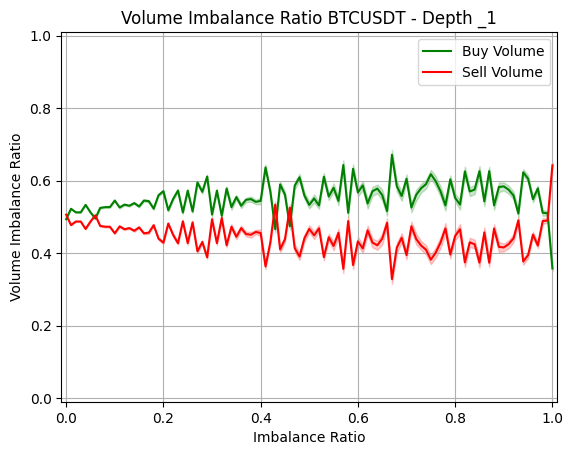

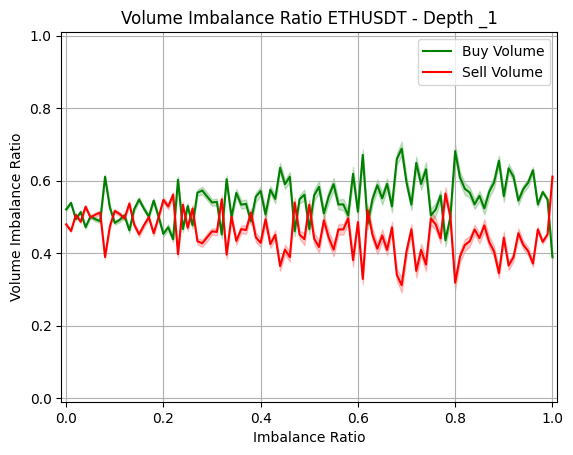

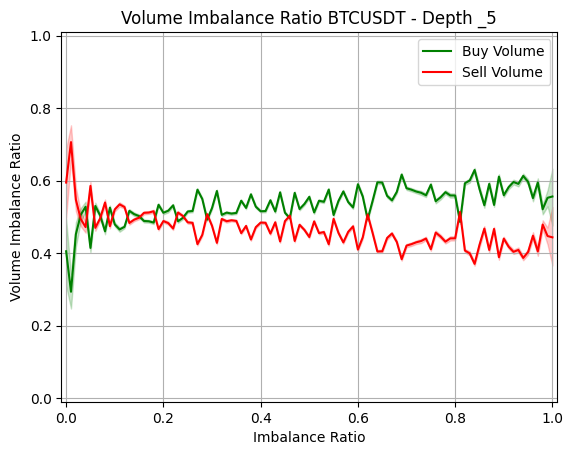

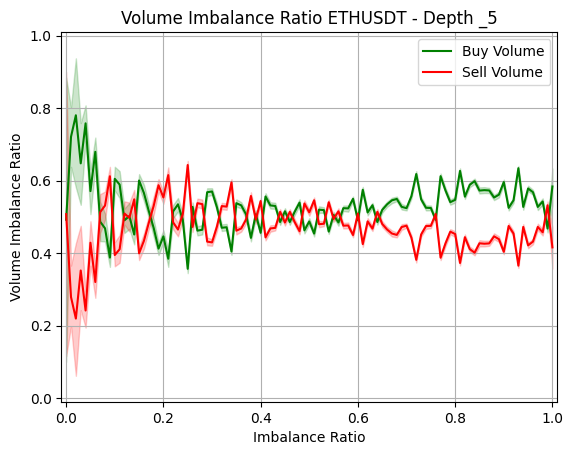

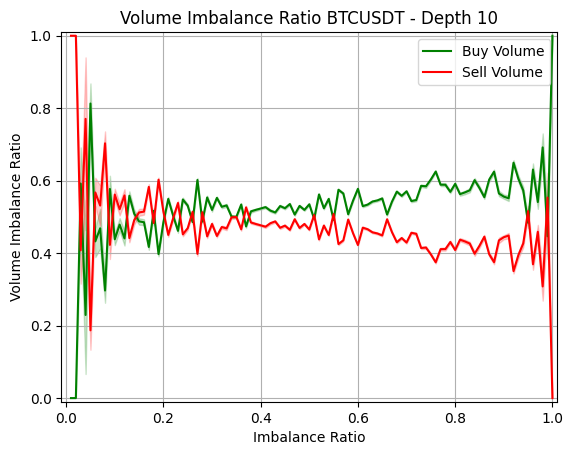

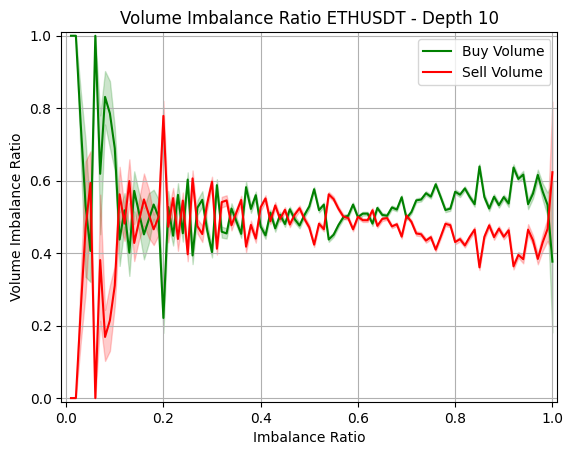

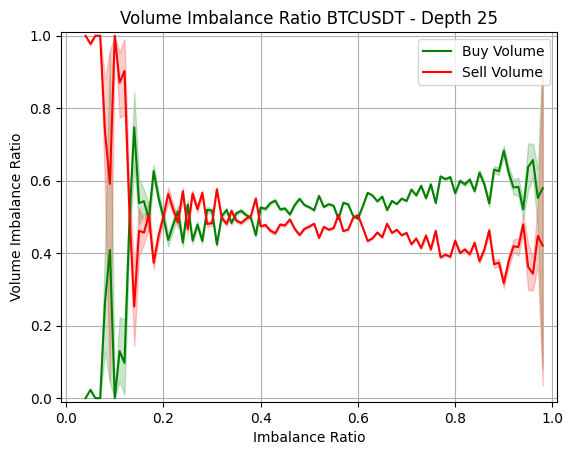

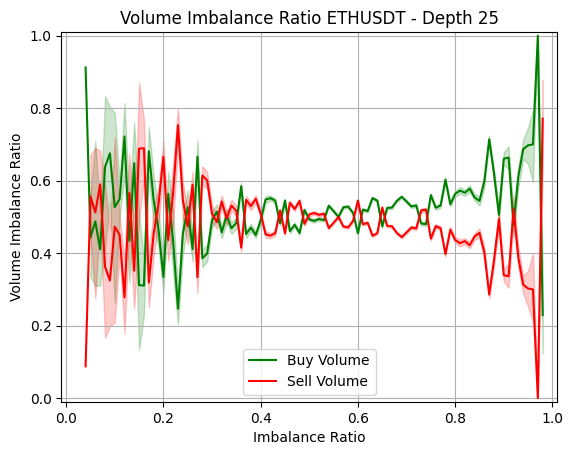

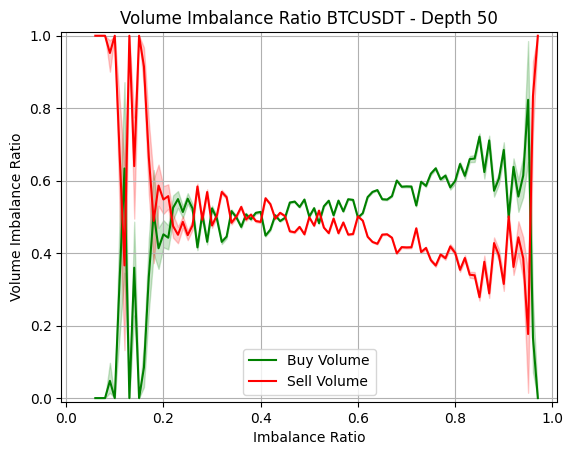

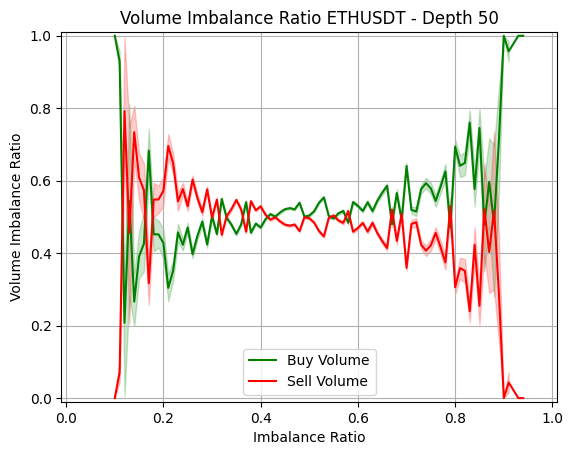

In [9]:
for imbalance_column in orderbook_imbalance_values:
    merged_df = pd.merge(buy_df[['symbol', imbalance_column, 'buy_amount']], sell_df[['symbol', imbalance_column, 'sell_amount']], on=['symbol', imbalance_column], how='outer').fillna(0)
    
    merged_df[f'buy_volume_imbalance_ratio_{imbalance_column[-2:]}'] = merged_df['buy_amount'] / (merged_df['buy_amount'] + merged_df['sell_amount'])
    merged_df[f'sell_volume_imbalance_ratio_{imbalance_column[-2:]}'] = merged_df['sell_amount'] / (merged_df['buy_amount'] + merged_df['sell_amount'])

    unique_symbols = merged_df['symbol'].unique()

    for symbol in unique_symbols:
        symbol_data = merged_df[merged_df['symbol'] == symbol]
        
        plt.figure()
        sns.lineplot(x=imbalance_column, y=f'buy_volume_imbalance_ratio_{imbalance_column[-2:]}', data=symbol_data, color='green', label='Buy Volume')
        sns.lineplot(x=imbalance_column, y=f'sell_volume_imbalance_ratio_{imbalance_column[-2:]}', data=symbol_data, color='red', label='Sell Volume')
        
        plt.title(f'Volume Imbalance Ratio {symbol} - Depth {imbalance_column[-2:]}')
        plt.xlabel('Imbalance Ratio')
        plt.ylabel('Volume Imbalance Ratio')
        plt.legend()
        plt.xlim(-0.01, 1.01)
        plt.ylim(-0.01, 1.01)
        plt.grid(True)
        plt.show()